In [1]:
from music21 import *
import json
import os

In [2]:
with open('arab_andalusian_music/arab-andalusian-scores-lines.json', 'r') as json_file:
    # Load the JSON data
    annotations = json.load(json_file)

In [3]:
folder_path = 'arab_andalusian_music/scores'
scores_folder = os.listdir(folder_path)
scores = {}

for i in range(len(scores_folder)):
    file_name = scores_folder[i]
    mbid = file_name.split('.xml')[0]
    file_path = os.path.join(folder_path, file_name)  
    
    try:
        for annotation in annotations:
            if annotation['mbid'] == mbid:
                score = converter.parse(file_path)
                scores[mbid] = {'score': score, 'annotations': annotation['sections']}

    except Exception as e:
        print(f"Error parsing file '{file_path}': {e}")

In [4]:
def parse_score_info(score_info):
    return score_info['score'], score_info['annotations']

In [5]:
scores

{'a451a7fc-c53f-462a-b3fc-4377bb588105': {'score': <music21.stream.Score 0x122c22920>,
  'annotations': [{'name': 'mišālia',
    'ṭab‘': 'al-māya',
    'mīzān': 'none',
    'start': 0.0,
    'end': 208.0},
   {'name': 'muassa‘',
    'ṭab‘': 'al-māya',
    'mīzān': 'bṭāyḥī',
    'start': 214.0,
    'ṣanā`i`': [{'name': 'muassa‘.1',
      'form': 'zejel',
      'start': 214.0,
      'lines': [{'name': 'muassa‘.1.1',
        'start': 214.0,
        'sections': [{'name': 'muassa‘.1.1.1', 'start': 214.0, 'end': 235.5},
         {'name': 'muassa‘.1.1.1', 'start': 262.0, 'end': 283.5},
         {'name': 'muassa‘.1.1.2', 'start': 286.0, 'end': 307.5},
         {'name': 'muassa‘.1.1.2', 'start': 310.0, 'end': 333.5}],
        'end': 333.5},
       {'name': 'muassa‘.1.2',
        'start': 334.0,
        'sections': [{'name': 'muassa‘.1.2.1', 'start': 334.0, 'end': 349.5},
         {'name': 'muassa‘.1.2.2', 'start': 350.0, 'end': 363.5}],
        'end': 363.5},
       {'name': 'muassa‘.1.3',
    

In [6]:
def extract_measures(score, start_offset, end_offset):
    extracted_part = stream.Stream()

    for element in score.getElementsByOffset(start_offset, end_offset, includeEndBoundary=False):
        extracted_part.append(element)

    return extracted_part


def extract_sections(score, score_sections):

    for section in score_sections:
        start_measure = section['start']
        end_measure = section['end']

        extracted_measures = extract_measures(score, start_measure, end_measure)
        section['score'] = extracted_measures

        if 'ṣanā`i`' in section:
            sanai = section['ṣanā`i`']
            num_sanai = len(sanai)

            for i in range(num_sanai):
                sana = sanai[i]
                sana_start = sana['start']
                sana_end = sana['end']
                sana_measures = extract_measures(score, sana_start, sana_end)
                section['ṣanā`i`'][i]['score'] = sana_measures

                if 'lines' in sana:
                    lines = sana['lines']
                    num_lines = len(lines)

                    for j in range(num_lines):
                        line = lines[j]
                        line_start = line['start']
                        line_end = line['end']
                        line_measures = extract_measures(score, line_start, line_end)
                        section['ṣanā`i`'][i]['lines'][j]['score'] = line_measures

                        if 'sections' in line:
                            line_sections = line['sections']
                            num_line_sections = len(line_sections)

                            for k in range(num_line_sections):
                                line_section = line_sections[k]
                                line_section_start = line_section['start']
                                line_section_end = line_section['end']
                                line_section_measures = extract_measures(score, line_section_start, line_section_end)
                                section['ṣanā`i`'][i]['lines'][j]['sections'][k]['score'] = line_section_measures

    return score_sections

In [7]:
for mbid in scores:
    score, annotations = parse_score_info(scores[mbid])

    flattened_score = score.parts[0].flatten().notesAndRests.stream()
    score_sections = extract_sections(flattened_score, annotations)

    scores[mbid]['annotations'] = score_sections

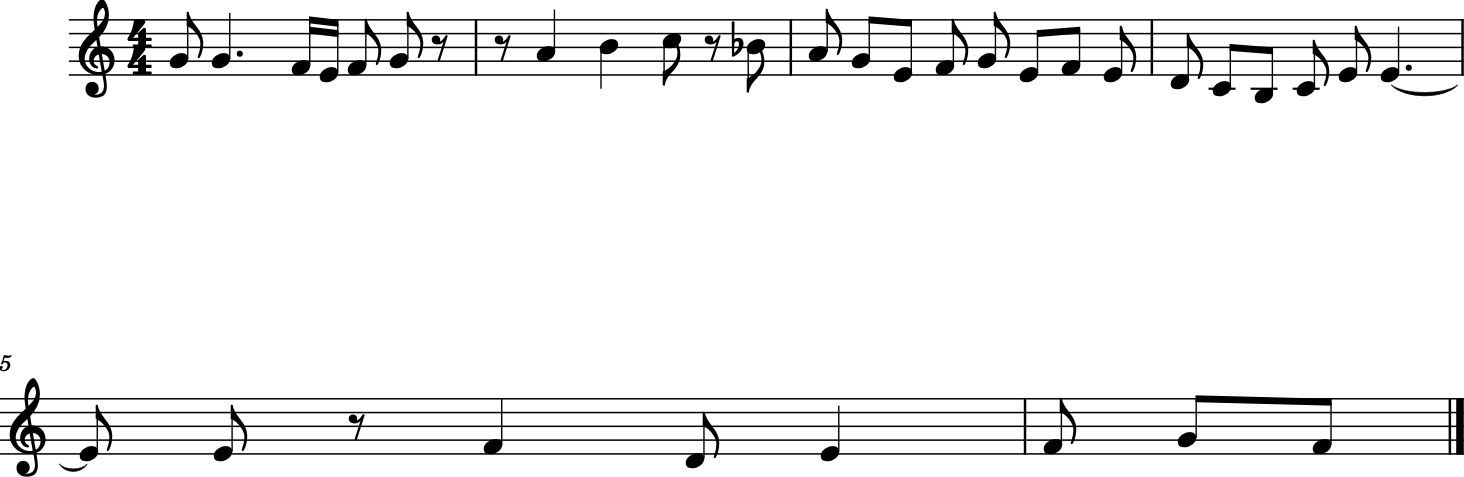

In [8]:
# sanity check that score parsing worked
scores['a451a7fc-c53f-462a-b3fc-4377bb588105']['annotations'][1]['ṣanā`i`'][0]['lines'][0]['sections'][0]['score'].show()

In [9]:
scores

{'a451a7fc-c53f-462a-b3fc-4377bb588105': {'score': <music21.stream.Score 0x122c22920>,
  'annotations': [{'name': 'mišālia',
    'ṭab‘': 'al-māya',
    'mīzān': 'none',
    'start': 0.0,
    'end': 208.0,
    'score': <music21.stream.Stream 0x122f817e0>},
   {'name': 'muassa‘',
    'ṭab‘': 'al-māya',
    'mīzān': 'bṭāyḥī',
    'start': 214.0,
    'ṣanā`i`': [{'name': 'muassa‘.1',
      'form': 'zejel',
      'start': 214.0,
      'lines': [{'name': 'muassa‘.1.1',
        'start': 214.0,
        'sections': [{'name': 'muassa‘.1.1.1',
          'start': 214.0,
          'end': 235.5,
          'score': <music21.stream.Stream 0x122f82c50>},
         {'name': 'muassa‘.1.1.1',
          'start': 262.0,
          'end': 283.5,
          'score': <music21.stream.Stream 0x123686f80>},
         {'name': 'muassa‘.1.1.2',
          'start': 286.0,
          'end': 307.5,
          'score': <music21.stream.Stream 0x123686fe0>},
         {'name': 'muassa‘.1.1.2',
          'start': 310.0,
         

In [10]:
# extract full sanai information and sanai scores
all_sanai = []
all_sanai_scores = []
all_sanai_lines_scores = []
for mbid in scores:
    score_info = scores[mbid]
    annotations = score_info['annotations']

    for section in annotations:
        if 'ṣanā`i`' in section:
            sanai = section['ṣanā`i`']
            all_sanai.extend(sanai)

            sana_count = 0
            for sana in sanai:
                all_sanai_scores.append(sana['score'])

                lines = sana['lines']
                all_lines_scores = []
                for line in lines:
                    all_lines_scores.append(line['score'])

                all_sanai_lines_scores.append(all_lines_scores)
                

In [11]:
score_section_counts = {}
sanai_count = 0
for mbid in scores:
    _, annotations = parse_score_info(scores[mbid])
    counts = {}

    for section in annotations:
        if 'ṣanā`i`' in section:
            sanai_count += 1

            this_sanai = 'sanai_' + str(sanai_count)
            if this_sanai not in counts:
                counts[this_sanai] = {}

            sana_count = 0
            for sana in section['ṣanā`i`']:
                sana_count += 1

                this_sana = 'sana_' + str(sana_count)
                if this_sana not in counts[this_sanai]:
                    counts[this_sanai][this_sana] = {}
                
                line_count = 0
                for line in sana['lines']:
                    line_count += 1

                    this_line = 'line_' + str(line_count)
                    if this_line not in counts[this_sanai][this_sana]:
                        counts[this_sanai][this_sana][this_line] = {}

                    line_section_count = 0
                    for line_section in line['sections']:
                        line_section_count += 1

                    counts[this_sanai][this_sana][this_line]['section_count'] = line_section_count

                counts[this_sanai][this_sana]['line_count'] = line_count
            
            counts[this_sanai]['sana_count'] = sana_count

        counts['sanai_count'] = sanai_count
    
    score_section_counts[mbid] = counts

In [12]:
score_section_counts

{'a451a7fc-c53f-462a-b3fc-4377bb588105': {'sanai_count': 3,
  'sanai_1': {'sana_1': {'line_1': {'section_count': 4},
    'line_2': {'section_count': 2},
    'line_3': {'section_count': 2},
    'line_4': {'section_count': 2},
    'line_5': {'section_count': 4},
    'line_count': 5},
   'sana_2': {'line_1': {'section_count': 2},
    'line_2': {'section_count': 2},
    'line_count': 2},
   'sana_3': {'line_1': {'section_count': 2},
    'line_2': {'section_count': 2},
    'line_3': {'section_count': 2},
    'line_4': {'section_count': 2},
    'line_5': {'section_count': 2},
    'line_count': 5},
   'sana_4': {'line_1': {'section_count': 2},
    'line_2': {'section_count': 2},
    'line_3': {'section_count': 2},
    'line_4': {'section_count': 2},
    'line_5': {'section_count': 2},
    'line_count': 5},
   'sana_count': 4},
  'sanai_2': {'sana_1': {'line_1': {'section_count': 2},
    'line_2': {'section_count': 2},
    'line_3': {'section_count': 2},
    'line_4': {'section_count': 2},
   

In [13]:
amin_cachoo_centos = [['A', 'G', 'F', 'E'], ['B-', 'A', 'G'], ['B', 'D', 'C'], ['C', 'B', 'A', 'G'], ['E', 'F', 'G'], ['F', 'G', 'E', 'F', 'E', 'D', 'C'], ['G', 'A', 'B', 'C']]
tf_idf_centos = [['G', 'F', 'E'], ['E', 'F', 'G'], ['A', 'G', 'F'], ['F', 'E', 'D'], ['E', 'D', 'C'], ['F', 'E', 'D', 'C'], ['A', 'G', 'F', 'E']]
sia_centos = [['A', 'G', 'F'], ['D', 'C', 'B'], ['E', 'D', 'C'], ['E', 'E', 'F'], ['E', 'F', 'E'], ['E', 'F', 'G'], ['F', 'E', 'D'], ['F', 'E', 'F']]
mgdp_centos = [['G', 'E', 'F'], ['F', 'G', 'E'], ['B-', 'A', 'G']]

In [24]:
def count_pattern_in_score(score, pattern):

    score_pitch_names = [n.name for n in score.getElementsByClass(note.Note)]

    score_length = len(score_pitch_names)

    # Count occurrences of the pattern in the score
    pattern_count = 0
    first_quarter_count = 0
    last_quarter_count = 0
    for i in range(len(score_pitch_names) - len(pattern) + 1):
        if score_pitch_names[i:i+len(pattern)] == pattern:
            pattern_count += 1
            if i < int(score_length * 0.25):
                first_quarter_count += 1
            elif i >= (score_length - int(score_length * 0.25)):
                last_quarter_count += 1

    return pattern_count, first_quarter_count, last_quarter_count


def count_all_patterns(score, patterns):
    pattern_counts = {}

    for pattern in patterns:
        pattern_str = ''.join(pattern)
        pattern_count = count_pattern_in_score(score, pattern)

        pattern_counts[pattern_str] = pattern_count

    return pattern_counts

In [38]:
def count_all_patterns_wrapper(scores, patterns):
    all_centos_counts = {}

    for mbid in scores:
        _, annotations = parse_score_info(scores[mbid])
        all_centos_counts[mbid] = {'sanai': {}, 'lines': {}}

        section_count = 0
        for section in annotations:
            section_count += 1

            if 'ṣanā`i`' in section:
                
                sana_count = 0
                for sana in section['ṣanā`i`']:
                    sana_count += 1
                    sana_score = sana['score']

                    which_sana = 'section_' + str(section_count) + '_sana_' + str(sana_count)
                    sana_pattern_counts = count_all_patterns(sana_score, patterns)
                    all_centos_counts[mbid]['sanai'][which_sana] = sana_pattern_counts

                    line_count = 0
                    for line in sana['lines']:
                        line_count += 1
                        line_score = line['score']

                        which_line = which_sana + '_line_' + str(line_count)
                        line_pattern_counts = count_all_patterns(line_score, patterns)
                        all_centos_counts[mbid]['lines'][which_line] = line_pattern_counts

    return all_centos_counts

In [39]:
all_amin_chachoo_centos_counts = count_all_patterns_wrapper(scores, amin_cachoo_centos)
all_tf_idf_centos_counts = count_all_patterns_wrapper(scores, tf_idf_centos)
all_sia_centos_counts = count_all_patterns_wrapper(scores, sia_centos)
all_mgdp_centos_counts = count_all_patterns_wrapper(scores, mgdp_centos)

In [43]:
all_sia_centos_counts

{'a451a7fc-c53f-462a-b3fc-4377bb588105': {'sanai': {'section_2_sana_1': {'AGF': (16,
     4,
     2),
    'DCB': (15, 4, 5),
    'EDC': (24, 6, 7),
    'EEF': (25, 6, 5),
    'EFE': (21, 8, 7),
    'EFG': (33, 11, 10),
    'FED': (27, 7, 8),
    'FEF': (18, 7, 5)},
   'section_2_sana_2': {'AGF': (26, 9, 5),
    'DCB': (11, 1, 4),
    'EDC': (12, 2, 4),
    'EEF': (29, 8, 6),
    'EFE': (13, 3, 4),
    'EFG': (17, 4, 4),
    'FED': (13, 3, 4),
    'FEF': (7, 2, 2)},
   'section_2_sana_3': {'AGF': (10, 5, 1),
    'DCB': (25, 6, 6),
    'EDC': (13, 4, 2),
    'EEF': (12, 6, 3),
    'EFE': (13, 4, 2),
    'EFG': (28, 7, 8),
    'FED': (20, 5, 5),
    'FEF': (1, 1, 0)},
   'section_2_sana_4': {'AGF': (25, 6, 6),
    'DCB': (22, 7, 5),
    'EDC': (40, 8, 11),
    'EEF': (40, 7, 12),
    'EFE': (66, 12, 19),
    'EFG': (35, 9, 9),
    'FED': (34, 8, 9),
    'FEF': (26, 4, 7)},
   'section_3_sana_1': {'AGF': (34, 9, 7),
    'DCB': (0, 0, 0),
    'EDC': (16, 4, 4),
    'EEF': (3, 0, 1),
    'EF

In [15]:
first_sana = all_sanai_scores[0]
example_cento = amin_cachoo_centos[0]
total_count, first_quarter_count, last_quarter_count = count_pattern_in_score(first_sana, example_cento)

In [16]:
total_count, first_quarter_count, last_quarter_count

(15, 4, 2)